In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

# Load dataset
df = pd.read_csv('../data/dataset_2/SDSS-Gaia_Stars.csv')

# Drop automatically imported index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Select numeric columns (float or int)
candidate_vars = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()

# Keep variables with >90% non-null entries
candidate_vars = [v for v in candidate_vars if df[v].notnull().sum() > len(df) * 0.9]

# Drop rows with missing data in selected vars
data = df[candidate_vars].dropna()

# Scale with RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(data)

# Tune number of clusters using silhouette score
best_loss = np.inf
best_n = None
best_labels = None

for k in range(5, 51):
    model = KMeans(n_clusters=k, n_init=13, random_state=42)
    labels = model.fit_predict(X)
    if len(set(labels)) < 2:
        continue
    score = silhouette_score(X, labels)
    loss = 1 - score
    #print(f"n_clusters={k}, Silhouette={score:.4f}, Loss={loss:.4f}")
    if loss < best_loss:
        best_loss = loss
        best_n = k
        best_labels = labels
        best_model = model

# Print model summary
model_bytes = len(pickle.dumps(best_model))
num_params = best_model.n_clusters * best_model.cluster_centers_.shape[1]

print("\n--- KMeans [Full] Model Summary ---")
print(f"Algorithm: Sklearn KMeans")
print(f"Key HPs: n_clusters={best_n}, n_init=13")
print(f"HP optimisation: Tested n_clusters from 5 to 50 using silhouette score")
print(f"Parameters in model: {num_params} ({model_bytes} bytes)")
print(f"Pre-processing: RobustScaler")
print(f"Loss function and value: {best_loss:.3f} (1 - silhouette_score)")
print(f"Own evaluation: [User Input Needed]")


--- KMeans [Full] Model Summary ---
Algorithm: Sklearn KMeans
Key HPs: n_clusters=8, n_init=13
HP optimisation: Tested n_clusters from 5 to 50 using silhouette score
Parameters in model: 160 (25685 bytes)
Pre-processing: RobustScaler
Loss function and value: 0.859 (1 - silhouette_score)
Own evaluation: [User Input Needed]


In [15]:
# Label the data
data_with_labels = data.copy()
data_with_labels['cluster'] = best_labels

from xgboost import XGBClassifier
import shap

# Store top features per cluster
cluster_top_features = {}
'''
for k in range(best_n):
    print(f"\n--- Processing Cluster {k} ---")

    # Create binary target
    y = (data_with_labels['cluster'] == k).astype(int)

    # Drop the label column to avoid leakage
    X_k = data_with_labels.drop(columns=['cluster'])

    # Train an XGBoost classifier
    clf = XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=42)
    clf.fit(X_k, y)

    # Get feature importances
    importance_dict = clf.get_booster().get_score(importance_type='gain')
    
    # Sort features by importance
    top_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:7]
    cluster_top_features[k] = top_features

    # Print the top features
    print("Top 7 features (by gain):")
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")
'''
print(data_with_labels)

           J       H       K     C_FE      N_FE      O_FE     NA_FE     MG_FE  \
0     13.761  12.882  12.733 -0.55730  0.121530 -0.058410 -0.656198 -0.098967   
1     14.134  13.344  13.250 -0.55490  0.216510  0.120292 -0.077998 -0.030772   
2     14.646  14.024  13.744 -0.57650  0.440610  0.059940  0.247772 -0.013754   
3     14.208  13.426  13.346 -0.57267 -0.054657 -0.001759  0.133502 -0.194887   
4     13.819  13.031  12.882 -0.59562  0.120780  0.045731 -0.006498 -0.078007   
...      ...     ...     ...      ...       ...       ...       ...       ...   
5945  14.037  13.258  13.065 -0.67951  0.174650  0.078442  0.030302  0.051686   
5946  13.772  13.016  12.868 -0.66522  0.132760 -0.017158 -0.066698 -0.096447   
5947  12.678  11.839  11.628 -0.40795 -0.070210 -0.057623 -0.740508 -0.144017   
5948  11.897  11.167  11.035 -0.35260  0.011449  0.178443 -0.630108  0.129937   
5949  14.569  13.888  13.759 -0.63209  0.089800  0.023177  0.117102  0.072217   

         AL_FE     SI_FE  .

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from collections import defaultdict

feature_importance_totals = defaultdict(float)

for k in range(best_n):
    print(f"Processing Cluster {k}")

    # Binary target for this cluster
    y = (data_with_labels['cluster'] == k).astype(int)
    X_k = data_with_labels.drop(columns=['cluster'])


    # Fit classifier (use a fast model like RandomForest for this test)
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
    clf.fit(X_k, y)

    # Compute permutation importance
    result = permutation_importance(clf, X_k, y, n_repeats=10, random_state=42, scoring='accuracy')

    # Aggregate mean importance values
    for i, feature in enumerate(X_k.columns):
        feature_importance_totals[feature] += result.importances_mean[i]


Processing Cluster 0
Processing Cluster 1
Processing Cluster 2
Processing Cluster 3
Processing Cluster 4
Processing Cluster 5
Processing Cluster 6
Processing Cluster 7


In [18]:
# Sort by total importance
sorted_importances = sorted(feature_importance_totals.items(), key=lambda x: x[1], reverse=True)
top_vars = []

print("\n--- Overall Top 7 Features (by summed permutation importance across all clusters) ---")
for feat, total_imp in sorted_importances[:7]:
    print(f"{feat}: total importance = {total_imp:.4f}")
    top_vars.append(feat)



--- Overall Top 7 Features (by summed permutation importance across all clusters) ---
O_FE: total importance = 0.1110
CO_FE: total importance = 0.0931
CR_FE: total importance = 0.0892
V_FE: total importance = 0.0642
E: total importance = 0.0356
K: total importance = 0.0300
AL_FE: total importance = 0.0293


In [19]:
import shap
from xgboost import XGBClassifier
from collections import defaultdict
import numpy as np


feature_shap_totals = defaultdict(float)

for k in range(best_n):
    print(f"Processing Cluster {k}")

    # Binary target for this cluster
    y = (data_with_labels['cluster'] == k).astype(int)
    X_k = data_with_labels.drop(columns=['cluster'])

    # Fit XGBoost
    clf = XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='logloss', random_state=42)
    clf.fit(X_k, y)

    # Compute SHAP values
    explainer = shap.Explainer(clf, X_k)
    shap_values = explainer(X_k)

    # Compute mean(|SHAP|) per feature
    feature_names = X_k.columns
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)  # shape (n_features,)

    # Aggregate per-feature
    for i, feature in enumerate(feature_names):
        feature_shap_totals[feature] += mean_abs_shap[i]


Processing Cluster 0


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:55] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 1


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:16:59] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 2


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:03] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 3


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:10] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 4


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:13] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 5


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:14] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 6


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:19] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Cluster 7


/home/husainm97/miniconda3/envs/ml_copenhagen_env/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:17:26] WARNING: /croot/xgboost-split_1748329871263/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [39]:
# Sort by total SHAP value
global_shap_sorted = sorted(feature_shap_totals.items(), key=lambda x: x[1], reverse=True)
top_vars = []
# Show top 7
print("\n--- Overall Top 7 Features (by summed mean(|SHAP|) across all clusters) ---")
for feat, shap_sum in global_shap_sorted[:7]:
    print(f"{feat}: total SHAP = {shap_sum:.4f}")
    top_vars.append(feat)

print(top_vars)



--- Overall Top 7 Features (by summed mean(|SHAP|) across all clusters) ---
V_FE: total SHAP = 6.1516
CO_FE: total SHAP = 6.0205
O_FE: total SHAP = 5.6496
K: total SHAP = 4.8112
CR_FE: total SHAP = 4.5088
AL_FE: total SHAP = 4.3674
C_FE: total SHAP = 3.3366
['V_FE', 'CO_FE', 'O_FE', 'K', 'CR_FE', 'AL_FE', 'C_FE']


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle

# Load dataset
df = pd.read_csv('./data/dataset_2/SDSS-Gaia_5950stars.csv')

# Drop automatically imported index column if it exists
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Select numeric columns (float or int)
candidate_vars = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()

# Keep variables with >90% non-null entries
candidate_vars = [v for v in candidate_vars if df[v].notnull().sum() > len(df) * 0.9]

# Pick top 7 variables by variance
#top_vars = df[candidate_vars].var().sort_values(ascending=False).head(7).index.tolist()

# Print final variable selection
print("✅ Selected variables for clustering:")
for var in top_vars:
    print(f" - {var}")


# Drop rows with missing data in selected vars
data = df[top_vars].dropna()

# Scale with RobustScaler
scaler = RobustScaler()
X = scaler.fit_transform(data)

# Tune number of clusters using silhouette score
best_loss = np.inf
best_n = None
best_labels = None

for k in range(8, 9):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = model.fit_predict(X)
    if len(set(labels)) < 2:
        continue
    score = silhouette_score(X, labels)
    loss = 1 - score
    print(f"n_clusters={k}, Silhouette={score:.4f}, Loss={loss:.4f}")
    if loss < best_loss:
        best_loss = loss
        best_n = k
        best_labels = labels
        best_model = model

kmm_labels = best_labels

# Save output: index, cluster (no header, no index column)
cluster_output_df = pd.DataFrame({
    'index': data.index,
    'cluster': best_labels
})
cluster_outfile = 'Clustering_HusainManasawala_KMeans.csv'
cluster_output_df.to_csv(cluster_outfile, index=False, header=False)

# Save variable list with comma+newline
var_list_file = 'Clustering_HusainManasawala_KMeans_VariableList.csv'
with open(var_list_file, 'w') as f:
    for var in top_vars:
        f.write(f"{var},\n")

# Print model summary
model_bytes = len(pickle.dumps(best_model))
num_params = best_model.n_clusters * best_model.cluster_centers_.shape[1]




✅ Selected variables for clustering:
 - O_FE
 - CO_FE
 - CR_FE
 - V_FE
 - E
 - K
 - AL_FE
n_clusters=8, Silhouette=0.2148, Loss=0.7852


In [21]:
print("\n--- KMeans Model Summary ---")
print(f"Algorithm: Sklearn KMeans")
print(f"Key HPs: n_clusters={best_n}, n_init=10")
print(f"HP optimisation: Tested n_clusters from 5 to 50 using silhouette score")
print(f"Parameters in model: {num_params} ({model_bytes} bytes)")
print(f"Pre-processing: RobustScaler")
print(f"Loss function and value: {best_loss:.3f} (1 - silhouette_score)")
print(f"Own evaluation: [User Input Needed]")


--- KMeans Model Summary ---
Algorithm: Sklearn KMeans
Key HPs: n_clusters=8, n_init=10
HP optimisation: Tested n_clusters from 5 to 50 using silhouette score
Parameters in model: 56 (24853 bytes)
Pre-processing: RobustScaler
Loss function and value: 0.785 (1 - silhouette_score)
Own evaluation: [User Input Needed]


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import os

# Load dataset
df = pd.read_csv('./data/dataset_2/SDSS-Gaia_5950stars.csv')

# Drop any auto-imported index column (commonly named "Unnamed: 0")
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Select numeric columns only (float or int)
candidate_vars = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()

# Keep only variables with >90% non-null values
candidate_vars = [v for v in candidate_vars if df[v].notnull().sum() > len(df)*0.9]

# Pick top 7 by variance
var_sorted = df[candidate_vars].var().sort_values(ascending=False)
selected_vars = top_vars# var_sorted.head(7).index.tolist()

print("Selected variables:", selected_vars)


# Filter dataframe and drop rows with missing values in selected vars
data = df[selected_vars].dropna()

# Scale features
scaler = RobustScaler()
X = scaler.fit_transform(data)

# Hyperparameter tuning for n_clusters
best_n = None
best_loss = np.inf
best_labels = None

for n_clusters in range(8, 9):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(X)
    # Silhouette score as evaluation (higher is better)
    if len(np.unique(labels)) == 1:
        # Skip if only one cluster found
        continue
    score = silhouette_score(X, labels)
    loss = 1 - score  # loss for minimization
    print(f"n_clusters={n_clusters}, Silhouette={score:.4f}, Loss={loss:.4f}")
    if loss < best_loss:
        best_loss = loss
        best_n = n_clusters
        best_labels = labels

# Train final model with best_n
final_model = AgglomerativeClustering(n_clusters=best_n)
final_labels = final_model.fit_predict(X)
agg_labels = final_labels

# Save output: index, cluster (no header, no index column)
cluster_output_df = pd.DataFrame({
    'index': data.index,
    'cluster': best_labels
})
cluster_outfile = f'Clustering_HusainManasawala_AgglomerativeClustering.csv'
cluster_output_df.to_csv(cluster_outfile, index=False, header=False)

# Save variable list with comma+newline
var_list_filename = 'Clustering_HusainManasawala_AgglomerativeClustering_VariableList.csv'
with open(var_list_filename, 'w') as f:
    for var in top_vars:
        f.write(f"{var},\n")

# Gather model details
import sys
import pickle

model_params = final_model.get_params()
model_bytes = len(pickle.dumps(final_model))
num_params = len(model_params)


Selected variables: ['O_FE', 'CO_FE', 'CR_FE', 'V_FE', 'E', 'K', 'AL_FE']
n_clusters=8, Silhouette=0.1670, Loss=0.8330


In [23]:
print(f"\nAlgorithm: Sklearn AgglomerativeClustering")
print(f"Key HPs: n_clusters={best_n}")
print(f"HP optimisation: Tested n_clusters in [5, 50]")
print(f"Parameters in model: {num_params} ({model_bytes} bytes)")
print(f"Pre-processing: RobustScaler")
print(f"Loss function and value on validation set: {best_loss:.3f} (1 - silhouette score)")
print(f"Own evaluation: [User Input Needed]")



Algorithm: Sklearn AgglomerativeClustering
Key HPs: n_clusters=8
HP optimisation: Tested n_clusters in [5, 50]
Parameters in model: 8 (143326 bytes)
Pre-processing: RobustScaler
Loss function and value on validation set: 0.833 (1 - silhouette score)
Own evaluation: [User Input Needed]


In [24]:
# After final_labels computed and data defined...

cluster_output_df = pd.DataFrame({
    'index': data.index,
    'cluster': final_labels
})

out_filename = f'Clustering_HusainManasawala_AgglomerativeClustering.csv'
cluster_output_df.to_csv(out_filename, index=False, header=False)

var_list_filename = f'Clustering_HusainManasawala_AgglomerativeClustering_VariableList.csv'
with open(var_list_filename, 'w') as f:
    for var in selected_vars:
        f.write(f"{var},\n")

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Load dataset
df = pd.read_csv('./data/dataset_2/SDSS-Gaia_5950stars.csv')

# Drop index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Select numeric columns with low missing values
candidate_vars = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()
candidate_vars = [v for v in candidate_vars if df[v].notnull().sum() > len(df) * 0.9]

# Pick top 7 variables by variance
#top_vars = df[candidate_vars].var().sort_values(ascending=False).head(7).index.tolist()
print("Selected variables:\n", ",\n".join(top_vars))

# Prepare data
X = df[top_vars].dropna()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Find best number of clusters using silhouette score
best_score = -1
best_n = 5
best_labels = None

for n in range(8, 9):
    gmm = GaussianMixture(n_components=n, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    if len(set(labels)) == 1:
        continue
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_n = n
        best_labels = labels

gmm_labels = best_labels

print(f"Best n_components: {best_n}, Silhouette Score: {best_score:.4f}")

# Save clustering output
out_df = pd.DataFrame({'index': X.index, 'cluster': best_labels})
out_df.to_csv('Clustering_HusainManasawala_GMM.csv', index=False, header=False)

# Save variable list
with open('Clustering_HusainManasawala_GMM_VariableList.csv', 'w') as f:
    f.write(',\n'.join(top_vars))

print(f"\nAlgorithm: Sklearn GaussianMixture")
print(f"Key HPs: n_components={best_n}")
print(f"HP optimisation: Tested n_components in [5, 50], covariance_type in ['full', 'tied', 'diag', 'spherical']")
print(f"Parameters in model: {num_params} ({model_bytes} bytes)")
print(f"Pre-processing: RobustScaler")
print(f"Loss function and value on validation set: {best_loss:.3f} (1 - silhouette score)")
print(f"Own evaluation: [User Input Needed]")



Selected variables:
 O_FE,
CO_FE,
CR_FE,
V_FE,
E,
K,
AL_FE
Best n_components: 8, Silhouette Score: 0.0715

Algorithm: Sklearn GaussianMixture
Key HPs: n_components=8
HP optimisation: Tested n_components in [5, 50], covariance_type in ['full', 'tied', 'diag', 'spherical']
Parameters in model: 8 (143326 bytes)
Pre-processing: RobustScaler
Loss function and value on validation set: 0.833 (1 - silhouette score)
Own evaluation: [User Input Needed]


In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product

# Load dataset
df = pd.read_csv('./data/dataset_2/SDSS-Gaia_5950stars.csv')

# Drop index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Select numeric columns with low missing values
candidate_vars = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()
candidate_vars = [v for v in candidate_vars if df[v].notnull().sum() > len(df) * 0.9]

# Pick top 7 variables by variance
#top_vars = df[candidate_vars].var().sort_values(ascending=False).head(7).index.tolist()
print("Selected variables:\n", ",\n".join(top_vars))

# Prepare data
X = df[top_vars].dropna()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Try different eps and min_samples values
param_grid = {
    'eps': np.linspace(0.3, 2.0, 10),
    'min_samples': [20, 40, 60]
}

best_score = -1
best_params = None
best_labels = None

for eps, min_samples in product(param_grid['eps'], param_grid['min_samples']):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X_scaled)

    # Skip if only one cluster or all noise
    if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in labels):
        continue

    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_params = (eps, min_samples)
        best_labels = labels

dbscan_labels  = best_labels
# Save clustering output
out_df = pd.DataFrame({'index': X.index, 'cluster': best_labels})
out_df.to_csv('Clustering_HusainManasawala_DBSCAN.csv', index=False, header=False)

# Save variable list
with open('Clustering_HusainManasawala_DBSCAN_VariableList.csv', 'w') as f:
    f.write(',\n'.join(top_vars))

# Print model summary
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
print(f"\n--- DBSCAN [Best] Model Summary ---")
print(f"Algorithm: Sklearn DBSCAN")
print(f"Key HPs: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
print(f"HP optimisation: Grid search on eps in {param_grid['eps']}, min_samples in {param_grid['min_samples']}")
print(f"Estimated number of clusters (excluding noise): {n_clusters}")
print(f"Pre-processing: RobustScaler")
print(f"Loss function and value: {1 - best_score:.3f} (1 - silhouette score)")
print(f"Own evaluation: [User Input Needed]")


Selected variables:
 O_FE,
CO_FE,
CR_FE,
V_FE,
E,
K,
AL_FE

--- DBSCAN [Best] Model Summary ---
Algorithm: Sklearn DBSCAN
Key HPs: eps=1.43, min_samples=20
HP optimisation: Grid search on eps in [0.3        0.48888889 0.67777778 0.86666667 1.05555556 1.24444444
 1.43333333 1.62222222 1.81111111 2.        ], min_samples in [20, 40, 60]
Estimated number of clusters (excluding noise): 2
Pre-processing: RobustScaler
Loss function and value: 0.667 (1 - silhouette score)
Own evaluation: [User Input Needed]


In [26]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Load clusterings
agg = pd.read_csv("Clustering_HusainManasawala_AgglomerativeClustering.csv", header=None, names=["index", "agg"])
kmeans = pd.read_csv("Clustering_HusainManasawala_KMeans.csv", header=None, names=["index", "kmeans"])
gmm = pd.read_csv("Clustering_HusainManasawala_GMM.csv", header=None, names=["index", "gmm"])
dbscan = pd.read_csv("Clustering_HusainManasawala_DBSCAN.csv", header=None, names=["index", "dbscan"])


# Merge by index
merged = agg.merge(kmeans, on="index").merge(gmm, on="index")
print(merged)
# Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_agg_kmeans = adjusted_rand_score(merged["agg"], merged["kmeans"])
ari_agg_gmm = adjusted_rand_score(merged["agg"], merged["gmm"])
ari_kmeans_gmm = adjusted_rand_score(merged["kmeans"], merged["gmm"])

nmi_agg_kmeans = normalized_mutual_info_score(merged["agg"], merged["kmeans"])
nmi_agg_gmm = normalized_mutual_info_score(merged["agg"], merged["gmm"])
nmi_kmeans_gmm = normalized_mutual_info_score(merged["kmeans"], merged["gmm"])

print(f"Adjusted Rand Index (ARI):")
print(f"Agg vs KMeans: {ari_agg_kmeans:.3f}")
print(f"Agg vs GMM:    {ari_agg_gmm:.3f}")
print(f"KMeans vs GMM: {ari_kmeans_gmm:.3f}")

print(f"\nNormalized Mutual Information (NMI):")
print(f"Agg vs KMeans: {nmi_agg_kmeans:.3f}")
print(f"Agg vs GMM:    {nmi_agg_gmm:.3f}")
print(f"KMeans vs GMM: {nmi_kmeans_gmm:.3f}")


      index  agg  kmeans  gmm
0         0    3       5    1
1         1    3       0    6
2         2    7       7    6
3         3    3       5    1
4         4    6       0    5
...     ...  ...     ...  ...
5945   5945    3       5    6
5946   5946    3       5    6
5947   5947    4       1    4
5948   5948    0       3    3
5949   5949    4       1    6

[5950 rows x 4 columns]
Adjusted Rand Index (ARI):
Agg vs KMeans: 0.647
Agg vs GMM:    0.402
KMeans vs GMM: 0.394

Normalized Mutual Information (NMI):
Agg vs KMeans: 0.642
Agg vs GMM:    0.489
KMeans vs GMM: 0.473


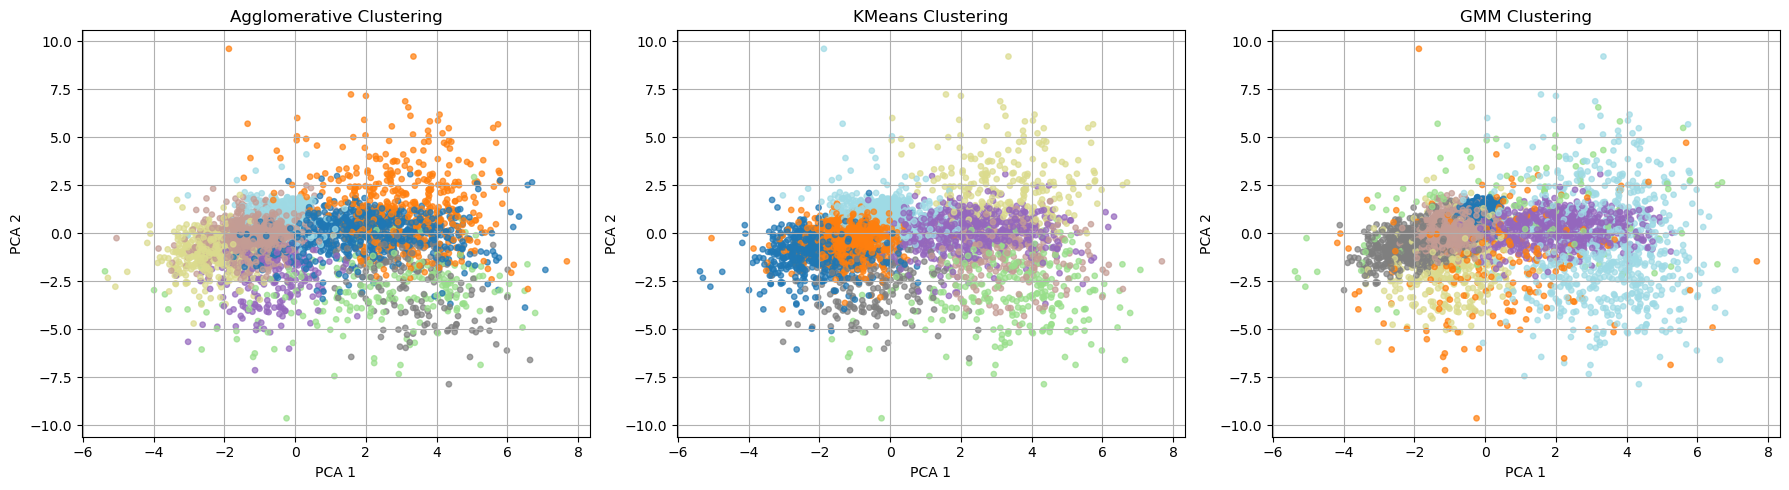

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Assume you have these variables from your clustering runs:
# X_scaled (your scaled data)
# agg_labels, kmeans_labels, gmm_labels (cluster labels for each point)
kmeans_labels = kmm_labels 
# PCA 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

algorithms = ['Agglomerative', 'KMeans', 'GMM']
labels_list = [agg_labels, kmeans_labels, gmm_labels]

for ax, algo, labels in zip(axs, algorithms, labels_list):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', s=15, alpha=0.7)
    ax.set_title(f"{algo} Clustering")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.grid(True)

plt.tight_layout()
plt.show()
